# dacon - 구내식당 식수 인원 예측 AI 경진대회

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", family = "Malgun Gothic")
import seaborn as sns
import warnings
warnings.filterwarnings(action = "ignore")
from tqdm.notebook import tqdm
from datetime import timedelta
from workalendar.asia import SouthKorea
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# data Load

In [236]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [237]:
train.shape, test.shape

((1205, 12), (50, 10))

In [238]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [239]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


# data cleaning & EDA

## 석식계가 0인 날

In [240]:
train[["중식계", "석식계", "현본사소속재택근무자수"]] = train[["중식계", "석식계", "현본사소속재택근무자수"]].astype("int")
test["현본사소속재택근무자수"] = test["현본사소속재택근무자수"].astype("int")

<AxesSubplot:xlabel='중식계', ylabel='Count'>

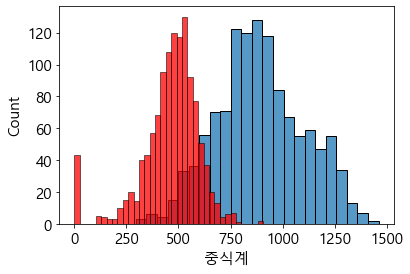

In [241]:
sns.histplot(x = "중식계", data = train)
sns.histplot(x = "석식계", color = "r", data = train)

석식계가 0인 날이 대략 40일 정도 있는 것으로 확인

In [242]:
din_nan = train.loc[train["석식계"] == 0]
din_nan[["일자", "요일", "석식메뉴", "석식계"]]

,일자,요일,석식메뉴,석식계
204,2016-11-30,수,*,0
224,2016-12-28,수,*,0
244,2017-01-25,수,*,0
262,2017-02-22,수,*,0
281,2017-03-22,수,*,0
306,2017-04-26,수,*,0
327,2017-05-31,수,자기계발의날,0
346,2017-06-28,수,*자기계발의날*,0
366,2017-07-26,수,가정의날,0
392,2017-09-01,금,*,0


석식계가 0인 날은 주로 월 중반 이후의 수요일로 **자기계발의날** 등의 사내 기념일로 추정

## 식사가 가능한 인원

In [243]:
train["식사가능자수"] = (train["본사정원수"] - train["본사휴가자수"] - train["현본사소속재택근무자수"]).astype(int)
test["식사가능자수"] = (test["본사정원수"] - test["본사휴가자수"] - test["현본사소속재택근무자수"]).astype(int)

휴가자와 재택근무자는 명백하게 본사에 출근하지 않았기 때문에 본사정원에서 제외하여 식사가능자수 열을 생성

<AxesSubplot:xlabel='본사시간외근무명령서승인건수', ylabel='석식계'>

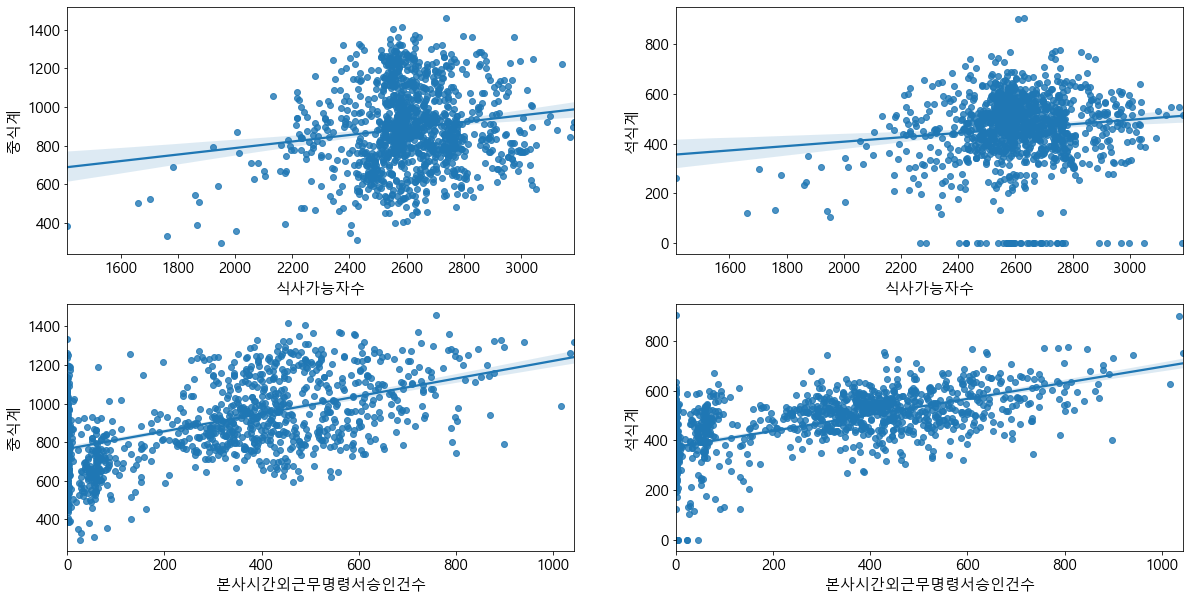

In [244]:
fig = plt.figure(figsize = (20, 10))
ax1, ax2, ax3, ax4 = fig.subplots(2, 2).flatten()

sns.regplot(x = "식사가능자수", y = "중식계", data = train, ax = ax1)
sns.regplot(x = "식사가능자수", y = "석식계", data = train, ax = ax2)
sns.regplot(x = "본사시간외근무명령서승인건수", y = "중식계", data = train, ax = ax3)
sns.regplot(x = "본사시간외근무명령서승인건수", y = "석식계", data = train, ax = ax4)

## 날짜 데이터

In [245]:
train["일자"] = pd.to_datetime(train["일자"])
train["년"] = train["일자"].dt.year
train["월"] = train["일자"].dt.month
train["주"] = train["일자"].dt.week
train["일"] = train["일자"].dt.day
train["요일"] = train["일자"].dt.weekday

test["일자"] = pd.to_datetime(test["일자"])
test["년"] = test["일자"].dt.year
test["월"] = test["일자"].dt.month
test["주"] = test["일자"].dt.week
test["일"] = test["일자"].dt.day
test["요일"] = test["일자"].dt.weekday

<AxesSubplot:xlabel='요일', ylabel='석식계'>

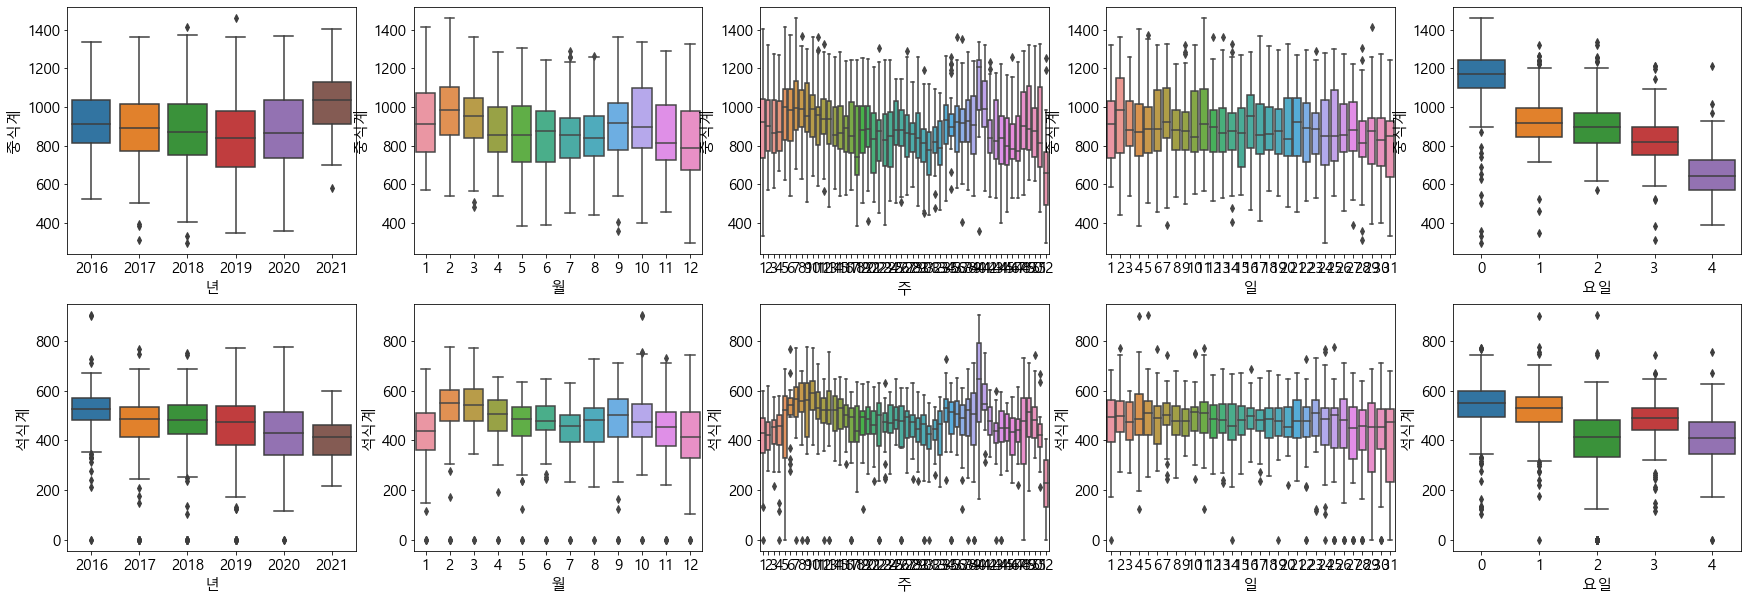

In [246]:
fig = plt.figure(figsize = (30, 10))
axs = fig.subplots(2, 5).flatten()

sns.boxplot(x = "년", y = "중식계", data = train, ax = axs[0])
sns.boxplot(x = "월", y = "중식계", data = train, ax = axs[1])
sns.boxplot(x = "주", y = "중식계", data = train, ax = axs[2])
sns.boxplot(x = "일", y = "중식계", data = train, ax = axs[3])
sns.boxplot(x = "요일", y = "중식계", data = train, ax = axs[4])

sns.boxplot(x = "년", y = "석식계", data = train, ax = axs[5])
sns.boxplot(x = "월", y = "석식계", data = train, ax = axs[6])
sns.boxplot(x = "주", y = "석식계", data = train, ax = axs[7])
sns.boxplot(x = "일", y = "석식계", data = train, ax = axs[8])
sns.boxplot(x = "요일", y = "석식계", data = train, ax = axs[9])

## 휴일 (공휴일 + 금요일)

In [247]:
train["일자"] = train["일자"].apply(lambda x: x.to_pydatetime().date())
test["일자"] = test["일자"].apply(lambda x: x.to_pydatetime().date())

In [248]:
holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2016))[:, 0]), 
                      pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2018))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2019))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2020))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2021))[:, 0])]).reset_index(drop = True)

In [249]:
yesterday = timedelta(days = -1)
prev_holidays = holidays + yesterday

In [250]:
train["휴일_prev"] = 0
for idx, day in enumerate(train["일자"]):
    if day in prev_holidays.values or train["요일"][idx] == 4:
        train["휴일_prev"][idx] = 1
        
test["휴일_prev"] = 0         
for idx, day in enumerate(test["일자"]):
    if day in prev_holidays.values or test["요일"][idx] == 4:
        test["휴일_prev"][idx] = 1

<AxesSubplot:xlabel='휴일_prev', ylabel='석식계'>

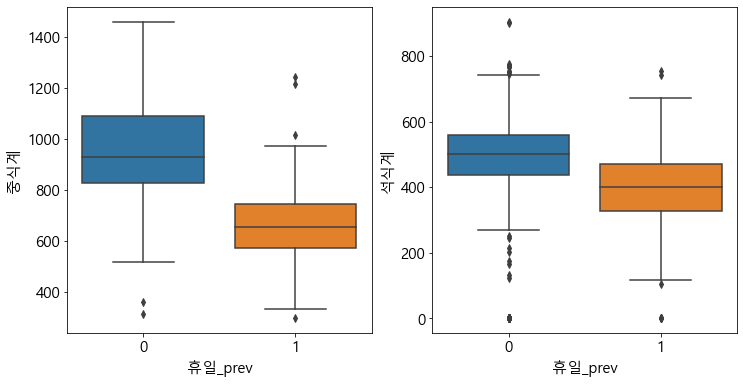

In [251]:
fig = plt.figure(figsize = (12, 6))
ax1, ax2 = fig.subplots(1, 2).flatten()

sns.boxplot(x = "휴일_prev", y = "중식계", data = train, ax = ax1)
sns.boxplot(x = "휴일_prev", y = "석식계", data = train, ax = ax2)

In [252]:
tomorrow = timedelta(days = 1)
next_holidays = holidays + tomorrow

In [253]:
train["휴일_next"] = 0
for idx, day in enumerate(train["일자"]):
    if day in next_holidays.values or train["요일"][idx] == 0:
        train["휴일_next"][idx] = 1
        
test["휴일_next"] = 0         
for idx, day in enumerate(test["일자"]):
    if day in next_holidays.values or test["요일"][idx] == 0:
        test["휴일_next"][idx] = 1

<AxesSubplot:xlabel='휴일_next', ylabel='석식계'>

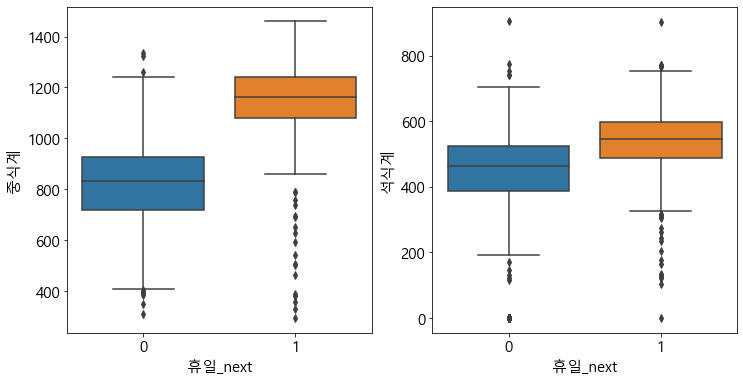

In [254]:
fig = plt.figure(figsize = (12, 6))
ax1, ax2 = fig.subplots(1, 2).flatten()

sns.boxplot(x = "휴일_next", y = "중식계", data = train, ax = ax1)
sns.boxplot(x = "휴일_next", y = "석식계", data = train, ax = ax2)

## heatmap

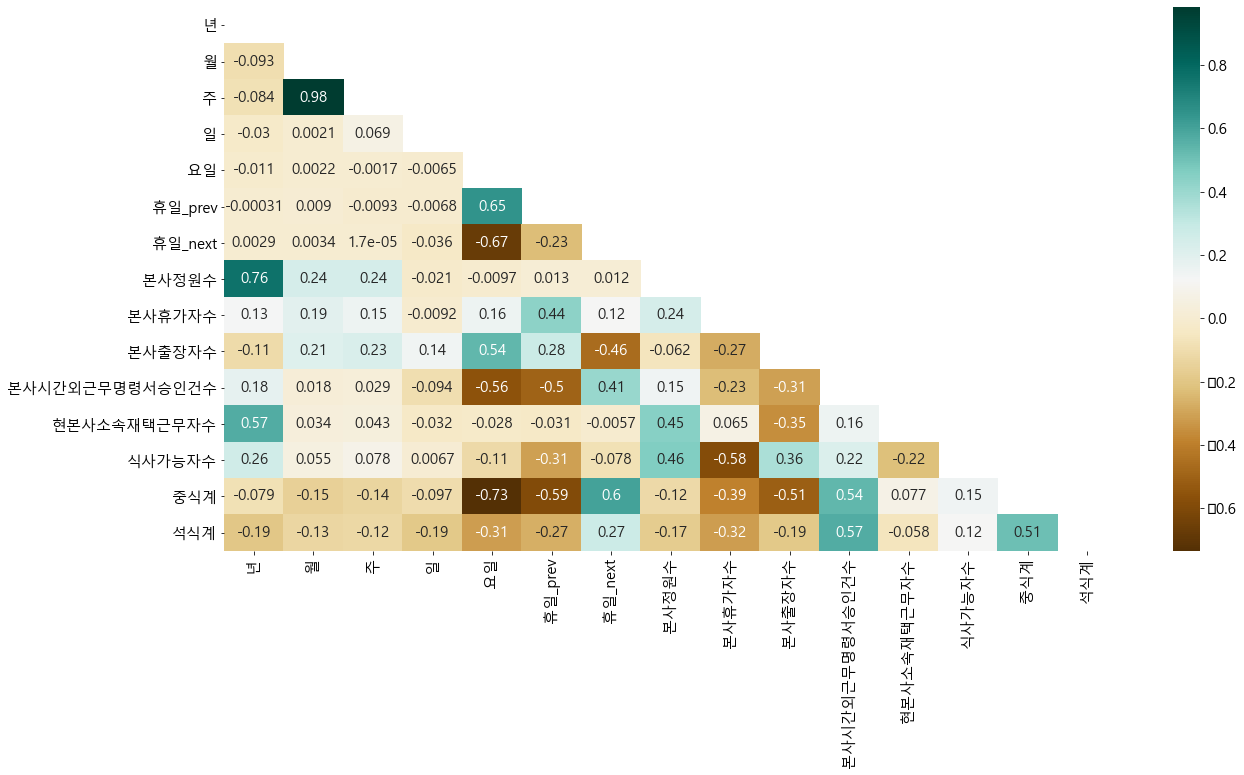

In [255]:
fig, ax = plt.subplots(figsize = (20, 10))

head_df = train[["년", "월", "주", "일", "요일", "휴일_prev", "휴일_next",
                 "본사정원수", "본사휴가자수", "본사출장자수", "본사시간외근무명령서승인건수",
                 "현본사소속재택근무자수", "식사가능자수",  "중식계", "석식계"]]
mask = np.triu(np.ones_like(df.corr(), dtype = np.bool))
sns.heatmap(head_df.corr(), annot = True, cmap="BrBG", mask = mask)
plt.show()

# train

## final dat set

In [256]:
use_col = ["월", "일", "요일", "휴일_prev", "식사가능자수", "본사출장자수", "본사시간외근무명령서승인건수"]

In [257]:
x1_train = train[use_col]
y1_train = train["중식계"]
x1_test = test[use_col]

x2_train = train[use_col]
y2_train = train["석식계"]
x2_test = test[use_col]

## xgboost

In [258]:
lunch = XGBRegressor(random_state = 42)
dinner = XGBRegressor(random_state = 42)

parameters = {
    "learning_rate": [0.1, 0.09, 0.089, 0.08],
    "objective": ["reg:squarederror"],
    "booster": ["gbtree", "gblinear", "dart"],
}

lunch_model = GridSearchCV(lunch, parameters, n_jobs = 6, scoring = "neg_mean_absolute_error")
dinner_model = GridSearchCV(dinner, parameters, n_jobs = 6, scoring = "neg_mean_absolute_error")

In [259]:
lunch_model.fit(x1_train, y1_train)
print(lunch_model.best_score_, lunch_model.best_params_)
best_lunch_model = lunch_model.best_estimator_
y1_pred = best_lunch_model.predict(x1_test)

-86.30547338461976 {'booster': 'gbtree', 'learning_rate': 0.089, 'objective': 'reg:squarederror'}


In [260]:
dinner_model.fit(x2_train, y2_train)
print(dinner_model.best_score_, dinner_model.best_params_)
best_dinner_model = dinner_model.best_estimator_
y2_pred = best_dinner_model.predict(x2_test)

-75.54937384484715 {'booster': 'gbtree', 'learning_rate': 0.08, 'objective': 'reg:squarederror'}


# submission

In [261]:
submission = pd.read_csv("./data/sample_submission.csv")

In [262]:
submission["중식계"] = y1_pred
submission["석식계"] = y2_pred
submission.head()

,일자,중식계,석식계
0,2021-01-27,1003.115173,266.596893
1,2021-01-28,998.831970,531.487244
2,2021-01-29,613.796265,224.706329
3,2021-02-01,1137.343994,597.292725
4,2021-02-02,1035.540039,583.390747


In [234]:
submission.to_csv("0623_allf_xgb_grid.csv", index = False)